### Nitish Shah, 160030005
### Project 2 Report
### CS 386
### 7th September, 2018

### Imports and dataset load

In [82]:
# Imports and dataset load

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

from itertools import combinations
from itertools import product

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
import seaborn as sns
import numpy as np
import sys

iris_df = sns.load_dataset("iris")
iris_df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
86,6.7,3.1,4.7,1.5,versicolor
135,7.7,3.0,6.1,2.3,virginica
21,5.1,3.7,1.5,0.4,setosa
81,5.5,2.4,3.7,1.0,versicolor
6,4.6,3.4,1.4,0.3,setosa


## 1. Visualize the Iris dataset using scatterplots

### Pair plot

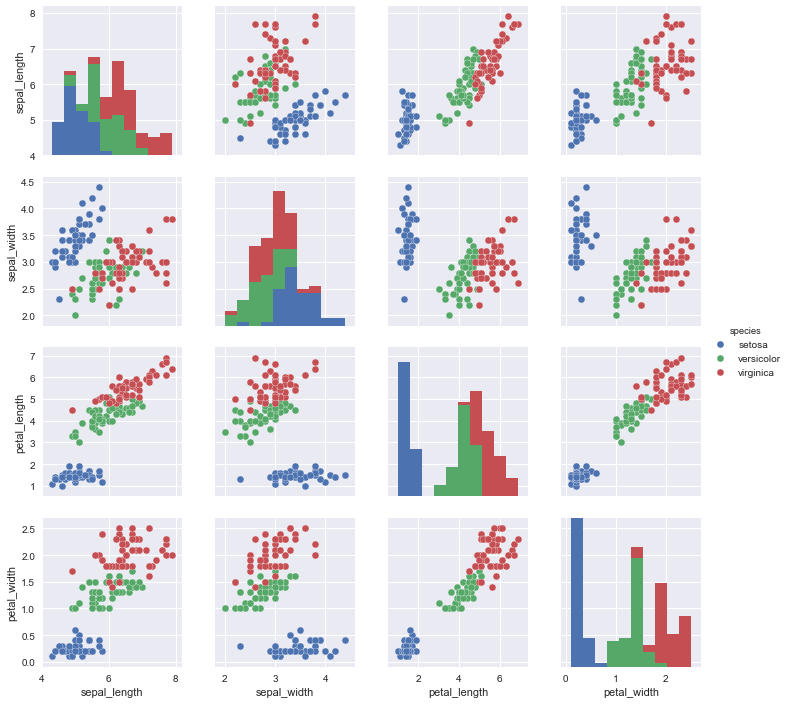

In [83]:
g = sns.pairplot(iris_df, hue='species')
plt.show()

Most of the scatter plots seem to have clustered data ( look seperate with some amount of mixing on the edges ), except in sepal_width ~ sepal_length.
This is also reflected in the correlation matrix below, which shows that their correlation is very low.

### Heatmap

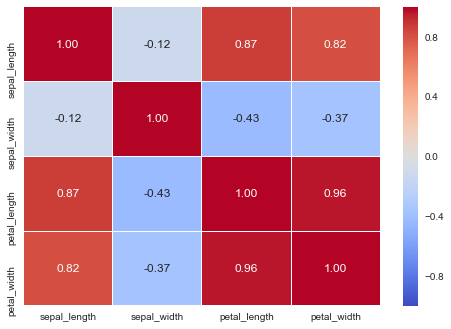

In [84]:
corr_mat = iris_df.corr()
sns.heatmap(corr_mat, annot=True, cmap="coolwarm",fmt='.2f', linewidths=.05)
plt.show()
# corr_mat

#### What conclusions could be drawn regarding the correlations among the numerical features in our dataset.

correlation of sepal_width with the rest of the features is weak, whereas all the rest of the features seem stromgly correlated with the rest. This can also be seen in the plots above, like in petal_width ~ petal_length plot where it can be clearly seen that one is positively correlated with the other. 

## 2 Visualize the Iris dataset using boxplots and histograms

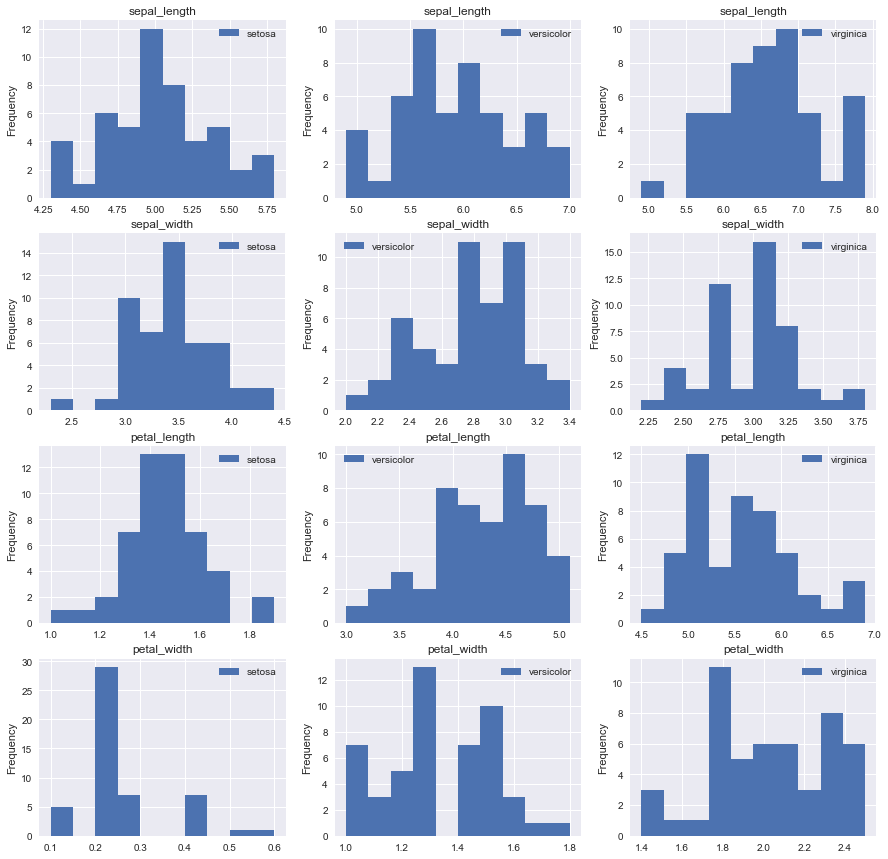

In [85]:
plt.figure(figsize=(15,15))
features = list(iris_df)
features.pop() # remove the last 'species' item 

iris_g = iris_df.groupby('species')

index = 0
for feature in features:
	for species_name, species_data in iris_g:
		index += 1
		ax = plt.subplot(4,3,index)
		species_data[feature].plot.hist(label=species_name)
		ax.set_title(feature)
		ax.legend()
plt.show()

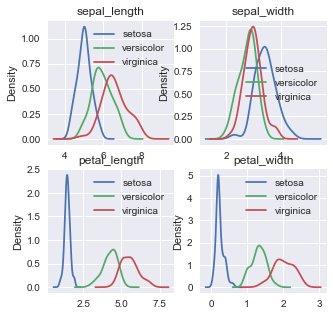

In [86]:
index = 0
plt.figure(figsize=(5,5))
for feature in features:
	index += 1
	ax = plt.subplot(2,2,index)
	for species_name, species_data in iris_g:
		# print(type(species_data[feature]))
		species_data[feature].plot.kde(label=species_name)
		ax.set_title(feature)
		ax.legend()
plt.show()

### State your inferences about the iris dataset

The histograms and kde plots ( drawn for a more clear picture of the data ) show that all the features for different species have a normal like distribution ( which is expected and can be seen in kde plots ), and that these distributions except for sepal_width have distinguishable means with some overlap with sepal_length.
sepal_width has a similar distribution for the three species, which would make it difficult to classify any new points solely based on its sepal_width.

Similar observations can be made from the box plots below.

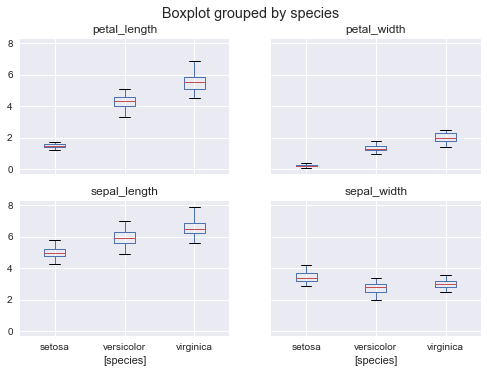

In [87]:
iris_df.boxplot(by='species')
plt.show()

## 3 Visualize the Iris dataset using 3D-plots

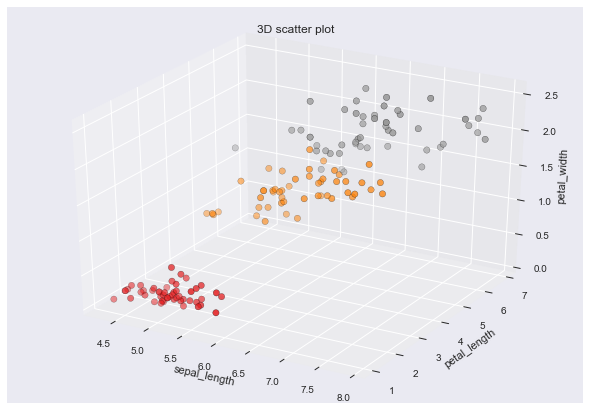

In [88]:
fig = plt.figure(1)
ax = Axes3D(fig)

to_plot = [0, 2, 3]
features = list(iris_df)   # columns of the pandas dataframe

ax.scatter( 
    iris_df[features[to_plot[0]]],
    iris_df[features[to_plot[1]]], 
    iris_df[features[to_plot[2]]], 
    c=pd.Categorical(iris_df.species).codes, 
    cmap=plt.cm.Set1, 
    edgecolor='k', 
    s=40
)

ax.set_title("3D scatter plot")

ax.set_xlabel(features[to_plot[0]])
# ax.w_xaxis.set_ticklabels([])
ax.set_ylabel(features[to_plot[1]])
# ax.w_yaxis.set_ticklabels([])
ax.set_zlabel(features[to_plot[2]])
# ax.w_zaxis.set_ticklabels([])

plt.show()

### Explain your observations

It can be seen, again, that the points of different species form 3 different clusters.
They forming these clusters makes it relatively easy to classify any new data, provided that the boundaries of these clusters are known.

## 4 Analyses of the k-means algorithm

### the K Means Class and some useful functions:


In [89]:
def cost_fn (data, centroids, target ):
	'''
		data numpy nd array n * m
		centroids k tuples like (a1, a2, ..., an)
		target, labeling of the data points integer from 1 to k
	'''
	cost = 0
	for k in range(len(centroids)):
		cost += np.sum(np.sqrt(np.sum((data[target == k] - centroids[k])**2, axis=1)))
	return cost

def euclidian_dist(x, y):
	'''
		 x and y are numpy arrays of the same dimensions 
	'''
	if x.shape != y.shape:
		raise ValueError('two points not of the same shape: ', x.shape, ' != ', y.shape)
	return np.sqrt( np.sum((x - y)**2) )

class kmeans:

	def __init__(self, dataset, k=0, max_iterations=50, cost_function=cost_fn, distance_function=euclidian_dist, tolerance=0.001, centroids=np.array([])):
		'''
				if k = 0: then algorithm chooses some k
				data = 2D numpy array
				cost function takes data and centroids and target ( assignments of data to a group ( integers ) )
				centroids = list or numpy array of points in the data space
			returns: a target and computed centroids
		'''
		if len(centroids) > k:
			# raise ValueError('Error: more centroids than number of clusters: '+ str(k) + ' given')
			print('Error: more centroids than number of clusters: '+ str(k) + ' given')
		self.k = k
		self.n, self.n_features = dataset.data.shape
		self.target = np.zeros(self.n, np.int)
		self.dataset = dataset
		self.data = dataset.data
		self.feature_names = dataset.feature_names
		self.max_iter = max_iterations
		self.cost_fn = cost_function
		self.dist_fn = distance_function
		self.tolerance = tolerance
		self.centroids = centroids
		self.costs = []

	def compute_centroids(self, show_graphs=False):
		'''
			centroids is list of indices of the data, some or all can be defined by the user
		'''
		tot = self.k - len(self.centroids)

		if tot < 0:
			print('Error: more centroids than ', self.k, 'given')

		# choose distinct centroids
		new_random_centroids = self.data[np.random.choice(len(self.data), tot, replace=False)]

		self.centroids = np.concatenate((self.centroids, new_random_centroids)) if self.centroids.size else new_random_centroids

		prev_cost = float('inf')
		new_cost = self.cost_fn(self.data, self.centroids, self.target)

		num_iterations = 0
		while abs(new_cost - prev_cost) > self.tolerance:

# 			print('iteration: ', num_iterations)
			num_iterations += 1

			if num_iterations > self.max_iter:
				return False

			# group points to nearest centroids
			self.target = np.argmin(np.sum((self.data - self.centroids[:, np.newaxis])**2, axis = 2), axis=0)

			# compute new centroids
			new_centroids = np.zeros_like(self.centroids)
			for k in range(len(self.centroids)):
				points_k = self.data[self.target == k]
				# print('k:', k, 'len', len(points_k))
				new_centroids[k] = np.sum(points_k, axis=0)/len(points_k)
			self.centroids = new_centroids

			# plot graph
			if show_graphs:
				title_ = "Calculated clusters using K-Means after iteration: " + str(num_iterations)
				self.scatter_plot(title=title_)

			prev_cost 	= new_cost
			new_cost = self.cost_fn(self.data, self.centroids, self.target)
			self.costs.append(abs(new_cost - prev_cost))
			if abs(new_cost - prev_cost) < self.tolerance:
				return True

	def show_clusters(self):
		pass

	def scatter_plot_with_orig_labels(self):
		self.scatter_plot(target=self.dataset.target, new_figure=True, title="Plot from true Labels")

	def scatter_plot(self, pause=0.2, target=np.array([]), new_figure=False, title=""):

		if target.size == 0:
			target = self.target

		if new_figure == True:
			plt.figure()
		else:
			plt.clf()

		plt.suptitle(title)
		for i in range(self.n_features):
			for j in range(self.n_features):
				if i > j:
					plt.subplot(self.n_features - 1, self.n_features - 1, i*(self.n_features-1) + j - 2 )
					X = self.data[:, [i, j]]
					centroids = self.centroids[:, [i, j]]
					Y = [self.feature_names[i], self.feature_names[j]]
					plt.ylabel(Y[0])
					plt.xlabel(Y[1])
					plt.scatter(X[:, 0], X[:, 1], c=target, cmap=plt.cm.Set2)
					plt.scatter(centroids[:, 0], centroids[:, 1], marker="x")

		plt.pause(pause)

	def cost_plot(self):
		plt.figure()
		plt.plot(self.costs)
		plt.xlabel('iterations')
		plt.ylabel('cost error')
		plt.suptitle('Cost Error Function Plot')
		plt.show()


### Initialize the k-means class

In [90]:
# load the iris dataset from scikit, more convenient than pandas dataframe
iris = datasets.load_iris()
clusters = kmeans(iris, 3)
clusters  # kmeans class object

### Cluster the dataset

In [91]:
if clusters.compute_centroids(show_graphs=False):
	print ('Clustering Done')
else:
	print('max iterations reached')


Clustering Done


### Plotting the results

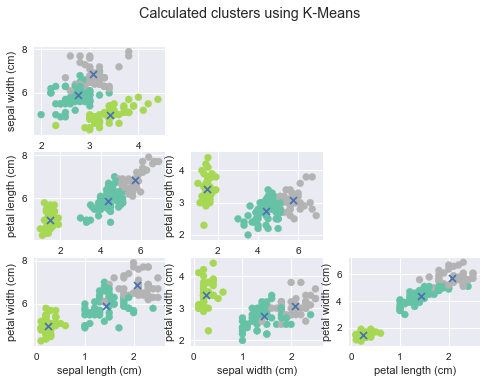

In [92]:
clusters.scatter_plot(title="Calculated clusters using K-Means")

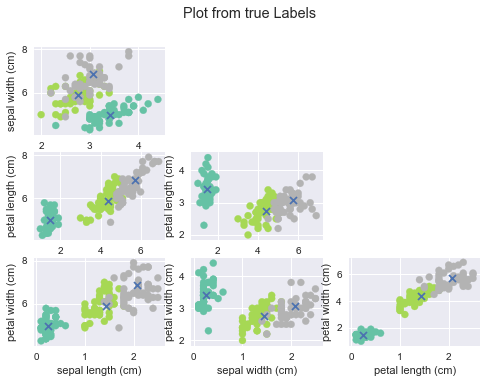

In [93]:
clusters.scatter_plot_with_orig_labels()

Seems to cluster the data well, most of the times.

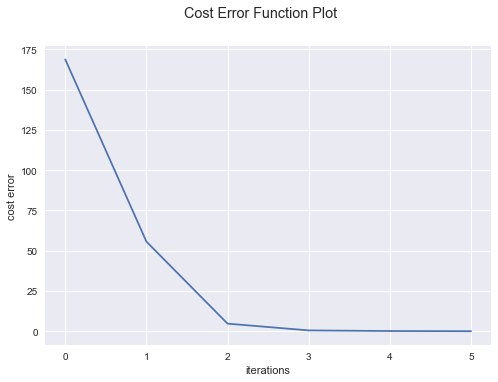

In [94]:
clusters.cost_plot()

The error converges to zero

### Suggest different ways to choose the number of iterations to get quality clusters
1. The algorithm cam stop when the assignment of points to different clusters doesn't change in that iteration Or when the centroids' position don't change after an iteration.
2. Convergence: The algorithm can stop when the cost function converges, ie when the difference between the last computed cost and the current cost are within some tolerance ( which is usually a small number like 1e-5 ) Or The algorithm can stop when some error function is sufficiently close to zero.
4. The algorithm can, of course, stops after some fixed maximum number of iterations.

## 5: Compare the results of both k -means and agglomerative clustering algorithms

### run k means and agglomerative clustering algorithms on the dataset

In [95]:
kmeans 			= KMeans(n_clusters=len(iris.target_names)).fit(iris.data)
agglo_ward  	= AgglomerativeClustering(n_clusters=len(iris.target_names), linkage='ward').fit(iris.data)

In [96]:
def euclidian_dist(x, y):
	'''
		 x and y are np arrays of the same dimensions 
	'''
	if x.shape != y.shape:
		raise ValueError('two points not of the same shape: ', x.shape, ' != ', y.shape)
	return np.sqrt( np.sum((x - y)**2) )

### Function to compare computed labels with the target labels 

In [97]:
def rename_computed_centroids_to_match_target(iris, model):

	# first compute the target and computed centroids

	target_centroids = np.zeros_like(iris.data[0])
	for i in range(len(iris.target_names)):
		target_centroids = np.vstack((target_centroids, np.mean(iris.data[iris.target == i], axis = 0)))
	target_centroids = target_centroids[1:]

	comp_centroids =  np.zeros_like(iris.data[0])
	for i in range(len(iris.target_names)):
		comp_centroids = np.vstack((comp_centroids, np.mean(iris.data[model.labels_ == i], axis = 0)))
	comp_centroids = comp_centroids[1:]

	# then match the computed centroids to the target ones which is the nearest
	tars = np.copy(target_centroids)
	comps = np.copy(comp_centroids)
	centroid_map = {}
	for i in range(len(tars)):
		closest = float('inf')
		closest_centroid_index =  np.zeros_like(tars[0])
		for j in range(len(comps)):
			dist = euclidian_dist(tars[i], comps[j])
			if dist < closest:
				closest = dist
				closest_centroid_index = j
		centroid_map[i] = closest_centroid_index
		np.delete(comps, j, 0)

	def map_(a, dict):
		return dict[a]

	vfunc = np.vectorize(map_)
	renamed_targets = vfunc( model.labels_ , centroid_map)

	# match
	not_same = renamed_targets == iris.target
	falses = len(not_same[not_same == False])
	total  = len(not_same)
	print('percentage points assigned same clusters = ', (total - falses)/total)
	print('\n')
	return renamed_targets


#### Computing the percentage of points in K-means and agglomerative clustering that were assigned with the right group 

In [98]:
print('K-Means: ')
kmeans.labels_ = rename_computed_centroids_to_match_target(iris, kmeans)
print('Agglomerative Clustering:')
agglo_ward.labels_ = rename_computed_centroids_to_match_target(iris, agglo_ward)

print('confusion_matrices:')
print('K-means: \n', metrics.confusion_matrix(iris.target, kmeans.labels_))
print('Agglomerative: \n', metrics.confusion_matrix(iris.target, agglo_ward.labels_))


K-Means: 
percentage points assigned same clusters =  0.8933333333333333


Agglomerative Clustering:
percentage points assigned same clusters =  0.8933333333333333


confusion_matrices:
K-means: 
 [[50  0  0]
 [ 0 48  2]
 [ 0 14 36]]
Agglomerative: 
 [[50  0  0]
 [ 0 49  1]
 [ 0 15 35]]


**The percentage of points that are assigned their target clusters are almost the same form both k-means and agglomerative clustering**

### Using some pre-defined performance evaluation methods from sci-kit learn:

In [99]:
print('Measure type            Kmeans             Agglomerative Clustering')
print('-----------------------------------------------------------------------')
a = round(metrics.completeness_score(iris.target, kmeans.labels_), 4)
b = round(metrics.completeness_score(iris.target, agglo_ward.labels_), 4)
print('completeness_score      ',a, '      ','>' if a > b else '<','       ', b)

a = round(metrics.homogeneity_score(iris.target, kmeans.labels_), 4)
b = round(metrics.homogeneity_score(iris.target, agglo_ward.labels_), 4)
print('homogeneity_score       ',a,'     ', '>' if a > b else '<','       ', b)

a = round(metrics.v_measure_score(iris.target, kmeans.labels_), 4)
b = round(metrics.v_measure_score(iris.target, agglo_ward.labels_), 4)
print('v_measure_score         ',a,'     ', '>' if a > b else '<','       ', b)

a = round(metrics.adjusted_rand_score(iris.target, kmeans.labels_), 4)
b = round(metrics.adjusted_rand_score(iris.target, agglo_ward.labels_), 4)
print('adjusted_rand_score     ',a,'     ', '>' if a > b else '<','       ', b)

a = round(metrics.silhouette_score(iris.data, kmeans.labels_, metric='euclidean'), 4)
b = round(metrics.silhouette_score(iris.data, agglo_ward.labels_, metric='euclidean'), 4)
print('silhouette_score        ',a,'     ', '>' if a > b else '<','       ', b)

Measure type            Kmeans             Agglomerative Clustering
-----------------------------------------------------------------------
completeness_score       0.765        <         0.7796
homogeneity_score        0.7515       <         0.7608
v_measure_score          0.7582       <         0.7701
adjusted_rand_score      0.7302       <         0.7312
silhouette_score         0.5526       <         0.5541


### Results
1. The percentage of points that are assigned their target clusters are almost the same form both k-means and agglomerative clustering.
2. The other pre-implemented scikit-learn performance evaluation measures show that Agglomerative clustering is marginally better than k-means on five of these scores, and agglomerative is better according to the calinski_harabax_sore.

All the scores are close enough, so it can be said that both the methods perform almost equally well on this dataset

#### Plotting functions

In [100]:
# plots
def scatter_plot_2d(data, target, title=""):
	plt.figure()
	plt.suptitle(title)
	n_features = len(data.feature_names)
	for i in range(n_features):
		for j in range(n_features):
			if i > j:
				plt.subplot(n_features - 1, n_features - 1, i*(n_features-1) + j - 2 )
				X = data.data[:, [i, j]]
				Y = [data.feature_names[i], data.feature_names[j]]
				plt.ylabel(Y[0])
				plt.xlabel(Y[1])
				plt.scatter(X[:, 0], X[:, 1], c=target, cmap=plt.cm.Set2)

def scatter_plot_3d(dataset, labels, features_to_plot, title=""):
	to_plot = [0, 2, 3]
	features = dataset.feature_names   # columns of the pandas dataframe

	fig = plt.figure()
	ax = Axes3D(fig)
	ax.scatter( 
		iris.data[:, [to_plot[0]]],
		iris.data[:, [to_plot[1]]], 
		iris.data[:, [to_plot[2]]], 
		c=labels,
		cmap=plt.cm.Set1, 
		edgecolor='k',
		s=40
	)
	ax.set_title(title)
	ax.set_xlabel(features[to_plot[0]])
	ax.set_ylabel(features[to_plot[1]])
	ax.set_zlabel(features[to_plot[2]])


#### plot 2d scatter plots for both the models and for the target dataset

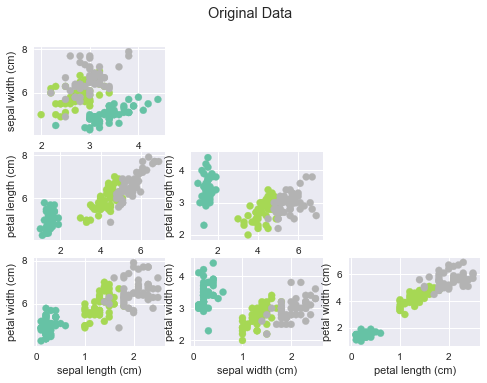

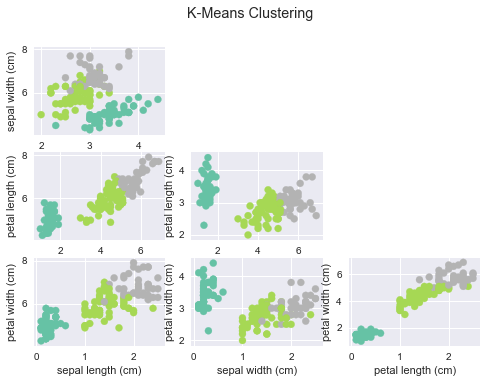

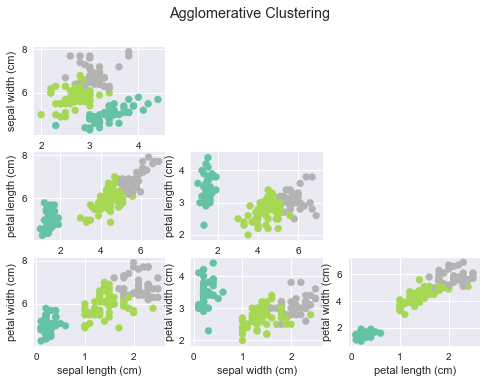

In [101]:
scatter_plot_2d(iris, iris.target, "Original Data")
scatter_plot_2d(iris, kmeans.labels_, "K-Means Clustering")
scatter_plot_2d(iris, agglo_ward.labels_, "Agglomerative Clustering")
plt.show()

#### plot 3d scatter plots for both the models and for the target dataset

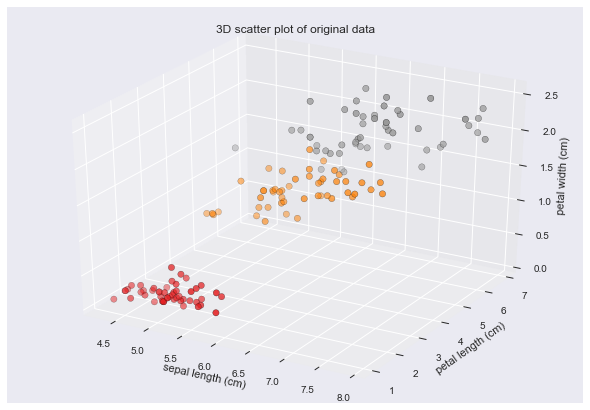

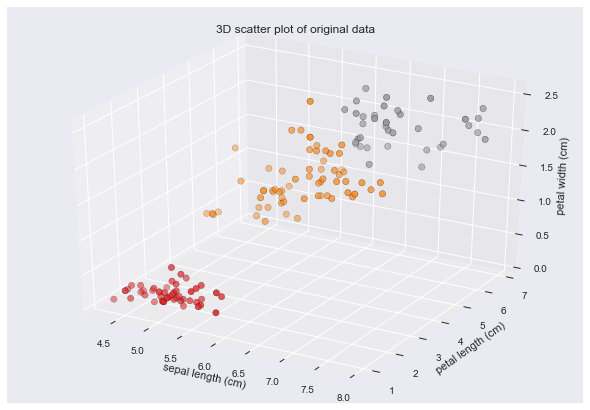

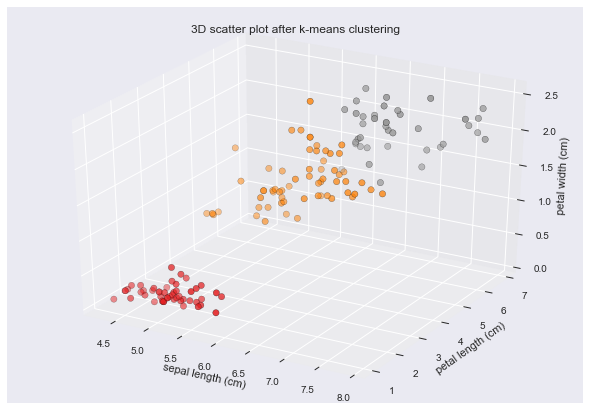

In [102]:
scatter_plot_3d(iris, iris.target, [0,2,3], "3D scatter plot of original data")
scatter_plot_3d(iris, agglo_ward.labels_, [0,2,3], "3D scatter plot of original data")
scatter_plot_3d(iris, kmeans.labels_, [0,2,3], "3D scatter plot after k-means clustering")
plt.show()

#### Both the 2d and 3d scatter plots of k-means and agglomerative clustering seem close enough to the target plots

## The effect of initial configuration on K-Means

The results of K-Means are highly sensitive to the choice of initial configuration. If chosen incorrectly, the algorithm will converge to a local minima of the cost function which may **not** be the global minima.
This can be rectified by running the algorithm some number of times (say 10) and picking the optimum results out of those.
This can ensure with a high probability (how high depends on the number) that the algorithm will find the global optimum of the cost function.

K-Means++ is an improvement over randomly choosing the initial points. It tries to select the points about uniformly spread in the data 

## 6. Selecting $k$ for K-Means

1. If the data can be visualised in an effective way, then the choice of $k$ can be made by just looking at the data, or in case of some huge dataset, but the number of features is not significant, then k may be chosen by looking a random sample, though this is not the case in majority applications.

2. If the data cannot be visualized, another obvious way to choose $k$ is by trial and error. Start with some small value, keep incrementing by some value till the cost function is sufficiently low, or if the cost function has some local minima. This $k$ should be significantly less than the size of data. These methods differ in their choice of the cost function. It is essential that this cost function is not monotonically increasing or decreasing, because if it is, then the algorithm may not stop.
  1. An example of the cost function is the average of silhuette coefficients of all the points in the data. Using this function to determine $k$ is called [**silhouette analysis**](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)
3. Another is the **elbow method**, which stops when the [explained variance](http://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score) **decreases abruptly** thus making it look like an elbow, which is where it gets its name from. The usual cost function(sum of distances from the cluster centroids) may also be used.

## 6. Selecting $k$ for Agglomerative clustering

1. The elbow method described above can also be used for agglomerative clustering methods, where the clustering joining is stopped when there is an abrupt change in the explained variance.
2. Silhouette analysis can also be used for this.

The difference between k-means and agglomerative is that k-means has to start over or different choices of $k$, but if the linkage methods in agglomerative methods is fixed, the algorithm doesn't have to start over, it can be run once, and using the children of each point, can divide the data in as many clusters as wanted.

#### silhouette analysis:

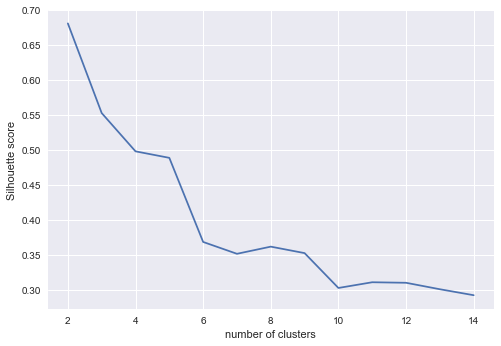

In [103]:
range_n = list(range(2,15))
kmeans_n = []
scores = []
for n in range_n:
	k = KMeans(n_clusters=n)
	k.fit(iris.data)
	scores.append(silhouette_score(iris.data, k.labels_))
	kmeans_n.append(k)

plt.plot(range_n, scores)
plt.xlabel('number of clusters')
plt.ylabel('Silhouette score')
plt.show()

The graph seems to increase its slope at around n = 3, 4 and 7, whick could be used as $k$

### Elbow Analysis

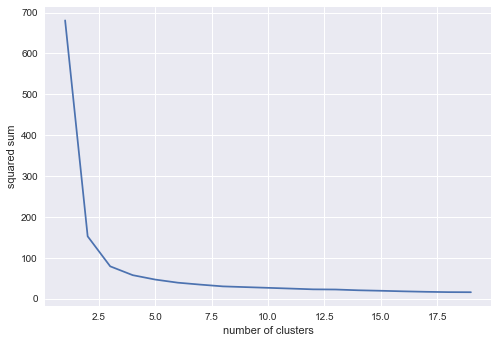

In [104]:
range_n_clusters = list(range(1, 20))
kmeans_all = []
ss = []

for n_clusters in range_n_clusters:
	data = iris.data
	kmeans_n = KMeans(n_clusters=n_clusters).fit(data)
	centroids = kmeans_n.cluster_centers_
	target = kmeans_n.labels_
	var = 0
	for k in range(len(kmeans_n.cluster_centers_)):
		var += np.sum(np.sum((data[target == k] - centroids[k])**2, axis=1))
	ss.append(var)

plt.plot(range_n_clusters, ss)
plt.xlabel('number of clusters')
plt.ylabel('squared sum')

plt.show()

Sharp turn of slope at about n = 3, whick can be taken as $k$

## Attachments

1. q1.py  # question 1, pair plots, histograms and heat map
2. q2.py  # question 2, 2d histograms, kde and box plots
3. q3.py  # question 3, 3d scatter plot
4. q4.py  # question 4, implements k means, plots results and graphs
5. q5.py  # question 5, compare k means and agglomerative, plots 2d and 3d scatter plots and prints confusion matrices
6. q6.py  # question 6, elbow and silhuette analysis

## References

http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set

